## Importing the Libraries

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
import plotly.graph_objects as go 
import joblib
from statsmodels.tsa.seasonal import seasonal_decompose

## Get the Data

In [2]:
data = pd.read_csv("./data/MicrosoftStock.csv")

#Check if data loaded successfully or not.
data

,index,date,open,high,low,close,volume,Name
0,390198,2013-02-08,27.35,27.710,27.3100,27.55,33318306,MSFT
1,390199,2013-02-11,27.65,27.920,27.5000,27.86,32247549,MSFT
2,390200,2013-02-12,27.88,28.000,27.7500,27.88,35990829,MSFT
3,390201,2013-02-13,27.93,28.110,27.8800,28.03,41715530,MSFT
4,390202,2013-02-14,27.92,28.060,27.8700,28.04,32663174,MSFT
...,...,...,...,...,...,...,...,...
1254,391452,2018-02-01,94.79,96.070,93.5813,94.26,47227882,MSFT
1255,391453,2018-02-02,93.64,93.970,91.5000,91.78,47867753,MSFT
1256,391454,2018-02-05,90.56,93.240,88.0000,88.00,51031465,MSFT
1257,391455,2018-02-06,86.89,91.475,85.2500,91.33,67998564,MSFT


## Data Visualization

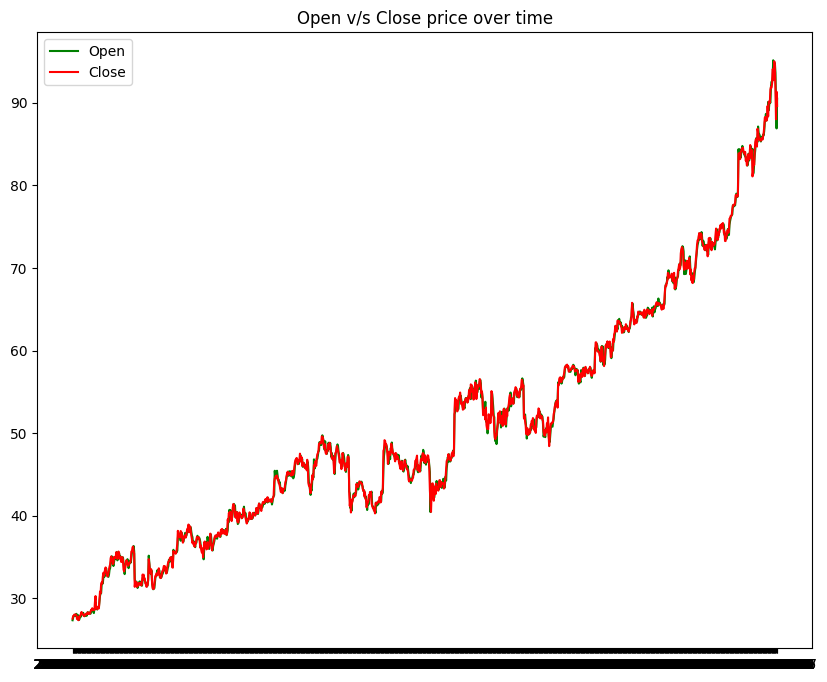

In [3]:
#Initial Data Visualization 
plt.figure(figsize=(10,8))
plt.plot(data['date'], data['open'] , label="Open", color="green")
plt.plot(data['date'], data['close'], label="Close", color="red")
plt.title("Open v/s Close price over time")
plt.legend()
plt.show()

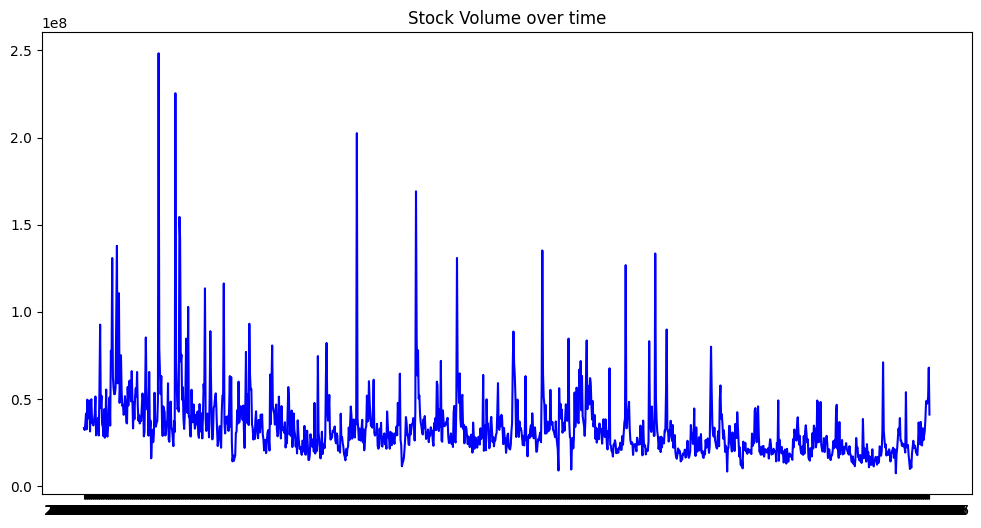

In [4]:
plt.figure(figsize=(12,6))
plt.plot(data['date'], data['volume'], label="Volume", color="blue")
plt.title("Stock Volume over time")
plt.show()

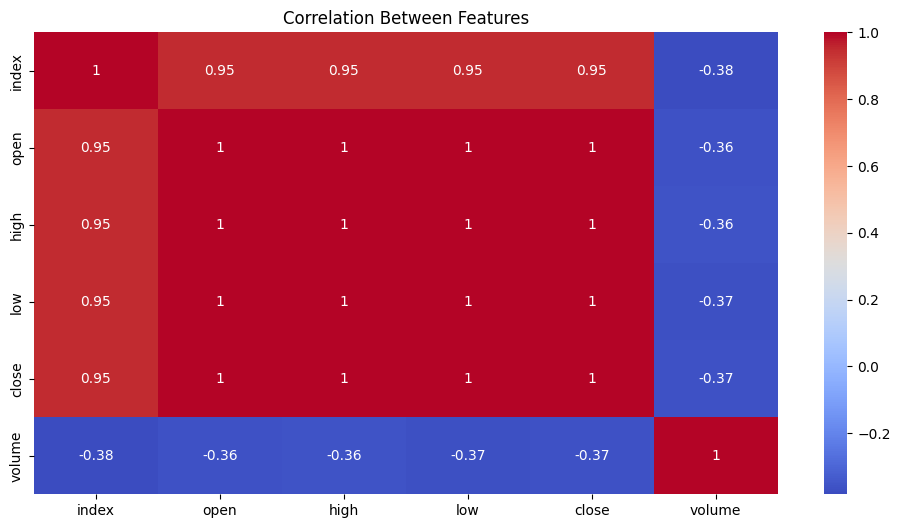

In [5]:
# Drop the non-numeric columns
numeric_data = data.select_dtypes(include=["int64","float64"])

#Check the correlation between the features
plt.figure(figsize=(12,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Features")
plt.show()

- From the heatmap we can get that the Volume feature does not correlate with other features.
- This is due to the fact that the Stock Volume does not depend on the Open/Close or Low/High prices of the stock.
- Whereas other features like Open Price is related to Close Price

In [6]:
# Convert the Data into datetime to create a datetime filter

data['date'] = pd.to_datetime(data['date'])

prediction = data.loc[
    (data['date'] > datetime(2013,1,1)) &
    (data['date'] < datetime(2018,1,1))
]

- Plot a graph to see if datetime is successfully implemented or not.

[]

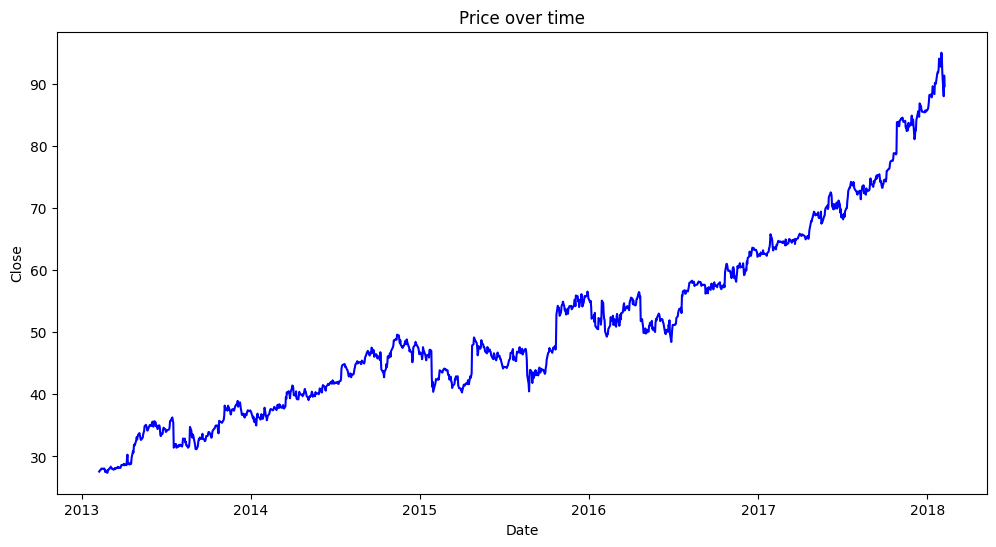

In [7]:
plt.figure(figsize=(12,6))
plt.plot(data['date'], data['close'], label="Open", color="blue")
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Price over time")
plt.plot()


## EDA

- #### Check for Null Values

In [8]:
df = data.copy()
print(f"Null Values Check:-\n{df.isnull().sum()}")

Null Values Check:-
index     0
date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64


- #### Candlestick Pattern

In [9]:
fig = go.Figure(data=[go.Candlestick(
    x = df['date'],
    open=df['open'],
    close=df['close'],
    high=df['high'],
    low=df['low'],
    increasing_line_color = 'green',
    decreasing_line_color = 'red'
)])

fig.update_layout(title="Microsoft Stock Data",
                  xaxis_title = 'Date',
                  yaxis_title='Price',
                  xaxis_rangeslider_visible = True)

fig.show()

- #### Seasonality Detection

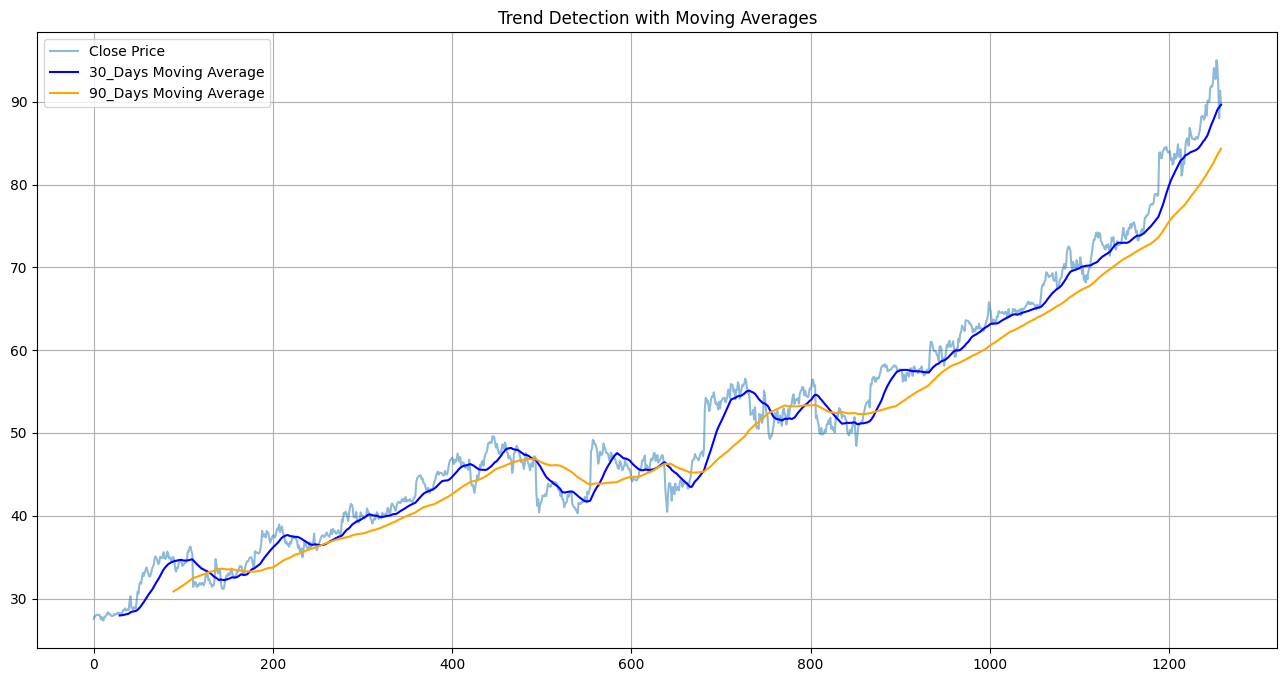

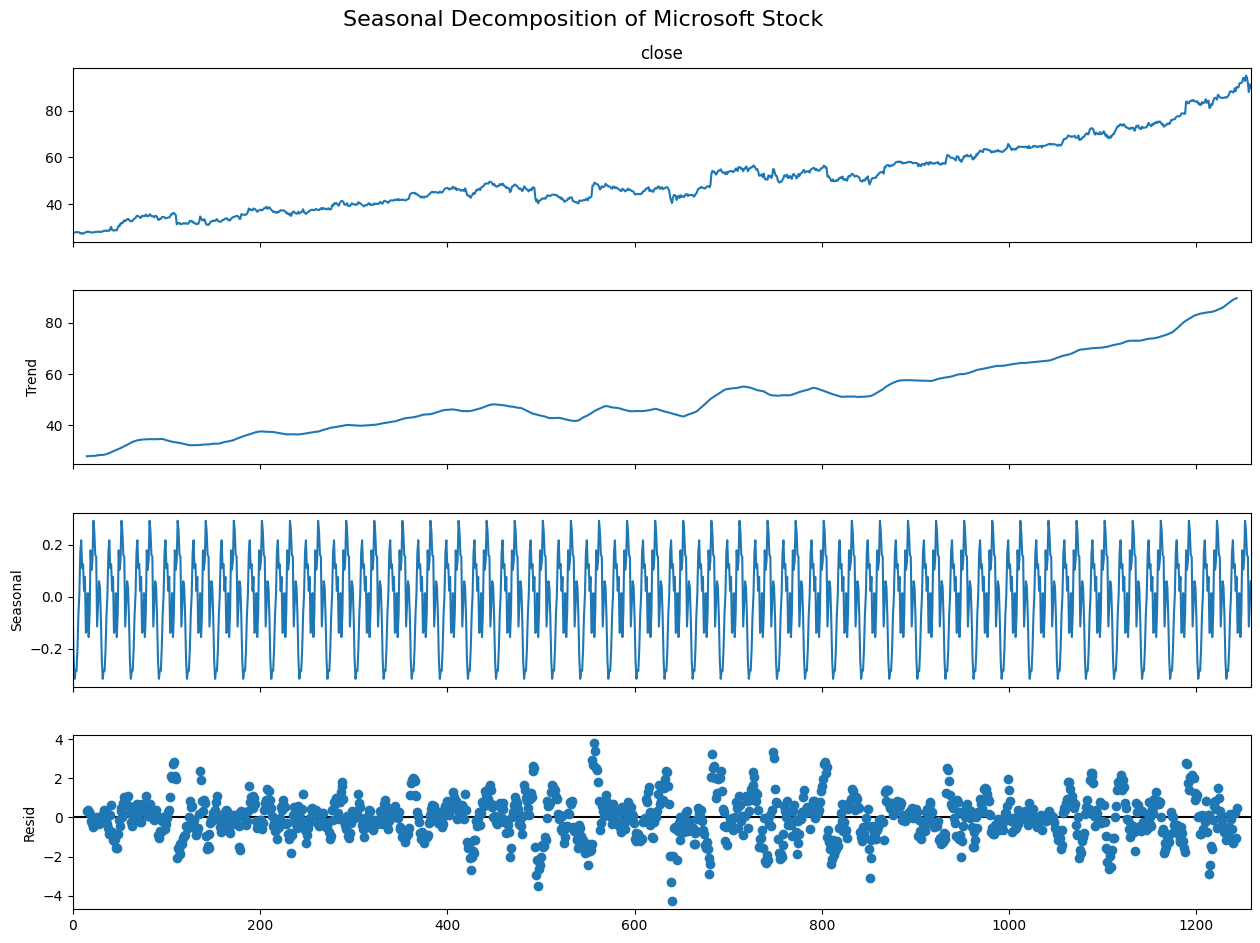

In [13]:
#Rolling Averages
df['MA_30'] = df['close'].rolling(window=30).mean()
df['MA_90'] = df['close'].rolling(window=90).mean()

#Plot original + rolling mean
plt.figure(figsize=(16,8))
plt.plot(df['close'], label="Close Price", alpha=0.5)
plt.plot(df['MA_30'], label='30_Days Moving Average', color='blue')
plt.plot(df['MA_90'], label='90_Days Moving Average', color='orange')
plt.title("Trend Detection with Moving Averages")
plt.legend()
plt.grid(True)
plt.plot()

#-------Seasonal Decomposition------------
decomposition = seasonal_decompose(df['close'], model='additive', period=30)
fig = decomposition.plot()
fig.set_size_inches(14,10)
plt.suptitle('Seasonal Decomposition of Microsoft Stock', fontsize=16)
plt.show()



### Data Preprocessing

In [15]:
stock_close = data.filter(['close'])

#Convert to Numpy Array 
dataset = stock_close.values 

#95% of the dataset will be training data
training_data_len = int(np.ceil(len(dataset) * 0.95))

scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

training_data = scaled_data[:training_data_len]

X_train, Y_train = [] , []

#Create a sliding window of 60 Days for our data.
for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i, 0])
    Y_train.append(training_data[i,0])
    
#Change the Train datasets to Numpy Array from List
X_train, Y_train = np.array(X_train), np.array(Y_train)

#Reshape the Numpy array 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))



    

    

In [16]:
test_data = scaled_data[training_data_len-60:]
X_test , Y_test = [] , dataset[training_data_len:]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0] , X_test.shape[1], 1))

## Model Architecture

##### Load the pre-trained model if available

In [ ]:
model = joblib.load('./models/model.pkl')

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,109 (684.02 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 116,740 (456.02 KB)

#### Run the following code if model is not available

In [17]:
model = Sequential()

#First Layer
model.add(LSTM(64, return_sequences=True, input_shape = (X_train.shape[1], 1)))

#Second Layer
model.add(LSTM(64, return_sequences=False))

#Third Layer {Layer will be Dense}
model.add(Dense(128, activation='relu'))

#Fourth Layer {Layer will be Dropout}
model.add(Dropout(0.5))

#Final Output layer
model.add(Dense(1))

model.summary()
model.compile(
    optimizer = "adam",
    loss = 'mae',
    metrics = [RootMeanSquaredError()]
)

c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

##### Training the Model

In [ ]:
training = model.fit(X_train, Y_train, epochs = 20, batch_size=32)



Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.3485 - root_mean_squared_error: 0.4863
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1303 - root_mean_squared_error: 0.1763
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1240 - root_mean_squared_error: 0.1673
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1140 - root_mean_squared_error: 0.1551
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1190 - root_mean_squared_error: 0.1640
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.1136 - root_mean_squared_error: 0.1553
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.1065 - root_mean_squared_error: 0.1499
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1042 - root_mean_squared_error: 0.1382
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0995 - root_mean_squared_error: 0.1351
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0967 - root_mean_squared_error: 0.1344

### Prediction/ Results

In [24]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 432ms/step


#### Visualizing the Predictions

- #### The model predicts only the last 62 days of values.

In [29]:
print(len(predictions) , len(df))

df['Predicted'] = np.nan

df.loc[df.index[-len(predictions):], 'Predicted'] = predictions

62 1259


In [30]:
df

,index,date,open,high,low,close,volume,Name,MA_30,MA_90,Predicted
0,390198,2013-02-08,27.35,27.710,27.3100,27.55,33318306,MSFT,NaN,NaN,NaN
1,390199,2013-02-11,27.65,27.920,27.5000,27.86,32247549,MSFT,NaN,NaN,NaN
2,390200,2013-02-12,27.88,28.000,27.7500,27.88,35990829,MSFT,NaN,NaN,NaN
3,390201,2013-02-13,27.93,28.110,27.8800,28.03,41715530,MSFT,NaN,NaN,NaN
4,390202,2013-02-14,27.92,28.060,27.8700,28.04,32663174,MSFT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1254,391452,2018-02-01,94.79,96.070,93.5813,94.26,47227882,MSFT,89.019000,83.583111,94.719948
1255,391453,2018-02-02,93.64,93.970,91.5000,91.78,47867753,MSFT,89.217333,83.788889,95.028168
1256,391454,2018-02-05,90.56,93.240,88.0000,88.00,51031465,MSFT,89.300000,83.952667,94.747139
1257,391455,2018-02-06,86.89,91.475,85.2500,91.33,67998564,MSFT,89.494333,84.146889,93.581779


In [31]:
len(predictions)

62

In [35]:
training_data_len
len(data) - training_data_len

62

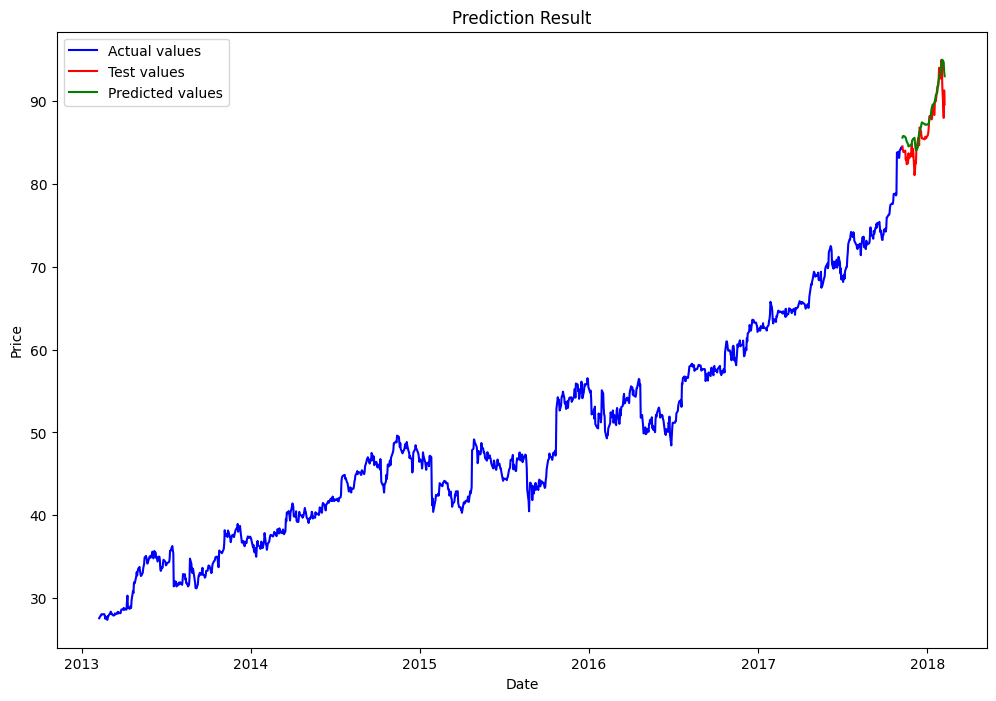

In [ ]:
train = data[:training_data_len] #This is taking the entries until the last 62 entries
test = data[training_data_len:] #This is taking the last 62 entries

test = test.copy()

test['predictions'] = predictions

plt.figure(figsize=(12,8))
plt.plot(train['date'], train['close'], label="Actual values", color='blue')
plt.plot(test['date'], test['close'], label="Test values", color='red')
plt.plot(test['date'], test['predictions'], label="Predicted values", color='green')
plt.title("Prediction Result")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()



## Evaluation Function to get the Accuracy of our model

In [41]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,root_mean_squared_error

In [37]:
df

,index,date,open,high,low,close,volume,Name,MA_30,MA_90,Predicted
0,390198,2013-02-08,27.35,27.710,27.3100,27.55,33318306,MSFT,NaN,NaN,NaN
1,390199,2013-02-11,27.65,27.920,27.5000,27.86,32247549,MSFT,NaN,NaN,NaN
2,390200,2013-02-12,27.88,28.000,27.7500,27.88,35990829,MSFT,NaN,NaN,NaN
3,390201,2013-02-13,27.93,28.110,27.8800,28.03,41715530,MSFT,NaN,NaN,NaN
4,390202,2013-02-14,27.92,28.060,27.8700,28.04,32663174,MSFT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1254,391452,2018-02-01,94.79,96.070,93.5813,94.26,47227882,MSFT,89.019000,83.583111,94.719948
1255,391453,2018-02-02,93.64,93.970,91.5000,91.78,47867753,MSFT,89.217333,83.788889,95.028168
1256,391454,2018-02-05,90.56,93.240,88.0000,88.00,51031465,MSFT,89.300000,83.952667,94.747139
1257,391455,2018-02-06,86.89,91.475,85.2500,91.33,67998564,MSFT,89.494333,84.146889,93.581779


In [43]:
def error_metrics(df, actual_col = 'close' , prediction_col = 'Predicted'):
    #Don't consider the Null Values
    valid_rows = df[[actual_col, prediction_col]].dropna()
    
    actual = valid_rows[actual_col]
    predicted = valid_rows[prediction_col]
    
    #Compute the error metrics
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = root_mean_squared_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual))*100
    
    print(f"Error Metrics on Last {len(valid_rows)} Rows")
    print("-"*50)
    print(f"Mean Absolute Error:- {mae:.2f}")
    print(f"Mean Squared Error:- {mse:.2f}")
    print(f"Root Mean Squared Error:- {rmse:.2f}")
    print(f"Mean Absolute Percentage Error:- {mape:.2f}%")
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

error_metrics(df)
    

Error Metrics on Last 62 Rows
--------------------------------------------------
Mean Absolute Error:- 1.39
Mean Squared Error:- 3.26
Root Mean Squared Error:- 1.81
Mean Absolute Percentage Error:- 1.62%


{'MAE': 1.3903148183514995,
 'MSE': 3.264710259974201,
 'RMSE': 1.8068509235612662,
 'MAPE': 1.6218547072564067}